In [4]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [5]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal
import sys
sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset = pickle.load(open("../../dataset.pkl", "rb"))
train_set, test_set = dataset.random_split_within_task(0.016)

# XGBoost 모델로 변경
tenset_model = XGBModelInternal()
# tenset_model.fit_base(train_set, valid_set=test_set)

In [6]:
# Dataset 필터링: throughput이 1e-10 이하인 데이터 제거
print("필터링 전 dataset 상태:")
for task in dataset.tasks():
    print(f"  Task {task}: {len(dataset.throughputs[task])} samples")

filtered_features = {}
filtered_throughputs = {}

total_before = 0
total_after = 0

for task in dataset.tasks():
    features = dataset.features[task]
    throughputs = dataset.throughputs[task]
    
    total_before += len(throughputs)
    
    # throughput > 1e-10인 데이터만 선택
    valid_indices = [i for i, t in enumerate(throughputs) if t > 1e-10]
    
    filtered_features[task] = features[valid_indices]
    filtered_throughputs[task] = throughputs[valid_indices]
    
    total_after += len(valid_indices)
    print(f"  Task {task}: {len(throughputs)} → {len(valid_indices)} samples (제거: {len(throughputs) - len(valid_indices)})")

# 필터링된 데이터로 dataset 업데이트
dataset.features = filtered_features
dataset.throughputs = filtered_throughputs

print(f"\n✅ 필터링 완료: {total_before} → {total_after} samples (제거: {total_before - total_after})")
print(f"제거 비율: {100 * (total_before - total_after) / total_before:.2f}%")

필터링 전 dataset 상태:
  Task LearningTask(workload_key='["0bcb8746286db050cd088f375c85372d", 1, 64, 64, 128, 6, 6, 32, 128, 1, 64, 64, 32]', target='cuda -keys=cuda,gpu -arch=sm_37 -max_num_threads=1024 -max_threads_per_block=1024 -registers_per_block=65536 -shared_memory_per_block=49152 -thread_warp_size=32'): 4000 samples
  Task LearningTask(workload_key='["0bcb8746286db050cd088f375c85372d", 1, 64, 64, 128, 6, 6, 32, 128, 1, 64, 64, 32]', target='cuda -keys=cuda,gpu -arch=sm_37 -max_num_threads=1024 -max_threads_per_block=1024 -registers_per_block=65536 -shared_memory_per_block=49152 -thread_warp_size=32'): 4000 → 3464 samples (제거: 536)

✅ 필터링 완료: 4000 → 3464 samples (제거: 536)
제거 비율: 13.40%


In [13]:
list(filtered_features.values())[0][1].shape

(8, 164)

In [32]:
# 필터링된 dataset으로 다시 train/test split
train_set, test_set = dataset.random_split_within_task(0.019)

print(f"\n훈련 세트: {sum(len(v) for v in train_set.throughputs.values())} samples")
print(f"테스트 세트: {sum(len(v) for v in test_set.throughputs.values())} samples")


훈련 세트: 65 samples
테스트 세트: 3399 samples


In [37]:
# XGBoost 모델 재학습
tenset_model = XGBModelInternal()
tenset_model.fit_base(train_set, valid_set=test_set)
print("✅ XGBoost 모델 재학습 완료!")

Fit a xgb booster. Train size: 65


/root/work/tenset/.venv/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


✅ XGBoost 모델 재학습 완료!


In [45]:
def pair_accuracy(cost_pred, labels):
    """
    cost_pred, labels: (B,) 텐서
    """
    n_samples = min(1000, len(cost_pred))
    sample_indices = np.random.choice(len(cost_pred), n_samples, replace=False)

    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                idx_i = sample_indices[i]
                idx_j = sample_indices[j]
                pred_diff = cost_pred[idx_i] - cost_pred[idx_j]
                true_diff = labels[idx_i] - labels[idx_j]
                if (pred_diff * true_diff) > 0:
                    correct += 1
                total += 1
        accuracy = correct / total if total > 0 else 0.0
    return accuracy

rank_acc = 0
for i in range(10):
    pred = tenset_model.predict(dataset)
    label_np = np.array(list(dataset.throughputs.values())[0])
    pred_np = np.array(list(pred.values())[0])
    pair_acc = pair_accuracy(pred_np, label_np)
    rank_acc += pair_acc
print(f"Pairwise Comparison Accuracy: {rank_acc / 10:.4f}")

Pairwise Comparison Accuracy: 0.8032


In [35]:
import numpy as np

def recall_at_k(pred, labels, k=1):
    pred = np.asarray(pred)
    labels = np.asarray(labels)

    true_best_idx = np.argmax(labels)
    topk_pred_idx = np.argpartition(pred, -k)[-k:]

    return float(true_best_idx in topk_pred_idx)



cost_pred = tenset_model.predict(dataset)
label_np = np.array(list(dataset.throughputs.values())[0])
pred_np = np.array(list(cost_pred.values())[0])

k = 100
recall_score = recall_at_k(pred_np, label_np, k=k)
print(f"Top-{k} Recall: {recall_score:.4f}")

Top-100 Recall: 0.0000


In [40]:
# XGBoost 모델 평가 (레이블을 -log(throughput)으로 변환)
print("\n" + "="*70)
print("XGBoost 모델 성능 평가")
print("="*70)

# 예측 수행
train_preds = tenset_model.predict(train_set)
test_preds = tenset_model.predict(test_set)

# 각 task별로 예측값과 실제값 수집
train_preds_all = []
train_targets_all = []
for task in train_set.tasks():
    train_preds_all.extend(train_preds[task])
    # -log(throughput)로 변환
    train_targets_all.extend(-np.log(train_set.throughputs[task]))

test_preds_all = []
test_targets_all = []
for task in test_set.tasks():
    test_preds_all.extend(test_preds[task])
    # -log(throughput)로 변환
    test_targets_all.extend(-np.log(test_set.throughputs[task]))

train_preds_all = np.array(train_preds_all)
train_targets_all = np.array(train_targets_all)
test_preds_all = np.array(test_preds_all)
test_targets_all = np.array(test_targets_all)

# 메트릭 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_metrics = {
    'mse': mean_squared_error(train_targets_all, train_preds_all),
    'mae': mean_absolute_error(train_targets_all, train_preds_all),
    'r2': r2_score(train_targets_all, train_preds_all),
    'rmse': np.sqrt(mean_squared_error(train_targets_all, train_preds_all))
}

test_metrics = {
    'mse': mean_squared_error(test_targets_all, test_preds_all),
    'mae': mean_absolute_error(test_targets_all, test_preds_all),
    'r2': r2_score(test_targets_all, test_preds_all),
    'rmse': np.sqrt(mean_squared_error(test_targets_all, test_preds_all))
}

print(f"\n훈련 세트 성능 (-log(throughput) 기준):")
print(f"  MSE:  {train_metrics['mse']:.6f}")
print(f"  RMSE: {train_metrics['rmse']:.6f}")
print(f"  MAE:  {train_metrics['mae']:.6f}")
print(f"  R²:   {train_metrics['r2']:.6f}")

print(f"\n테스트 세트 성능 (-log(throughput) 기준):")
print(f"  MSE:  {test_metrics['mse']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE:  {test_metrics['mae']:.6f}")
print(f"  R²:   {test_metrics['r2']:.6f}")

print("\n" + "="*70)


XGBoost 모델 성능 평가

훈련 세트 성능 (-log(throughput) 기준):
  MSE:  6.034846
  RMSE: 2.456592
  MAE:  2.011485
  R²:   -2.464410

테스트 세트 성능 (-log(throughput) 기준):
  MSE:  7.145460
  RMSE: 2.673099
  MAE:  2.201921
  R²:   -2.627122


훈련 세트 성능 (-log(throughput) 기준):
  MSE:  6.034846
  RMSE: 2.456592
  MAE:  2.011485
  R²:   -2.464410

테스트 세트 성능 (-log(throughput) 기준):
  MSE:  7.145460
  RMSE: 2.673099
  MAE:  2.201921
  R²:   -2.627122



/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/4055244445.py:48: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_103312/40552

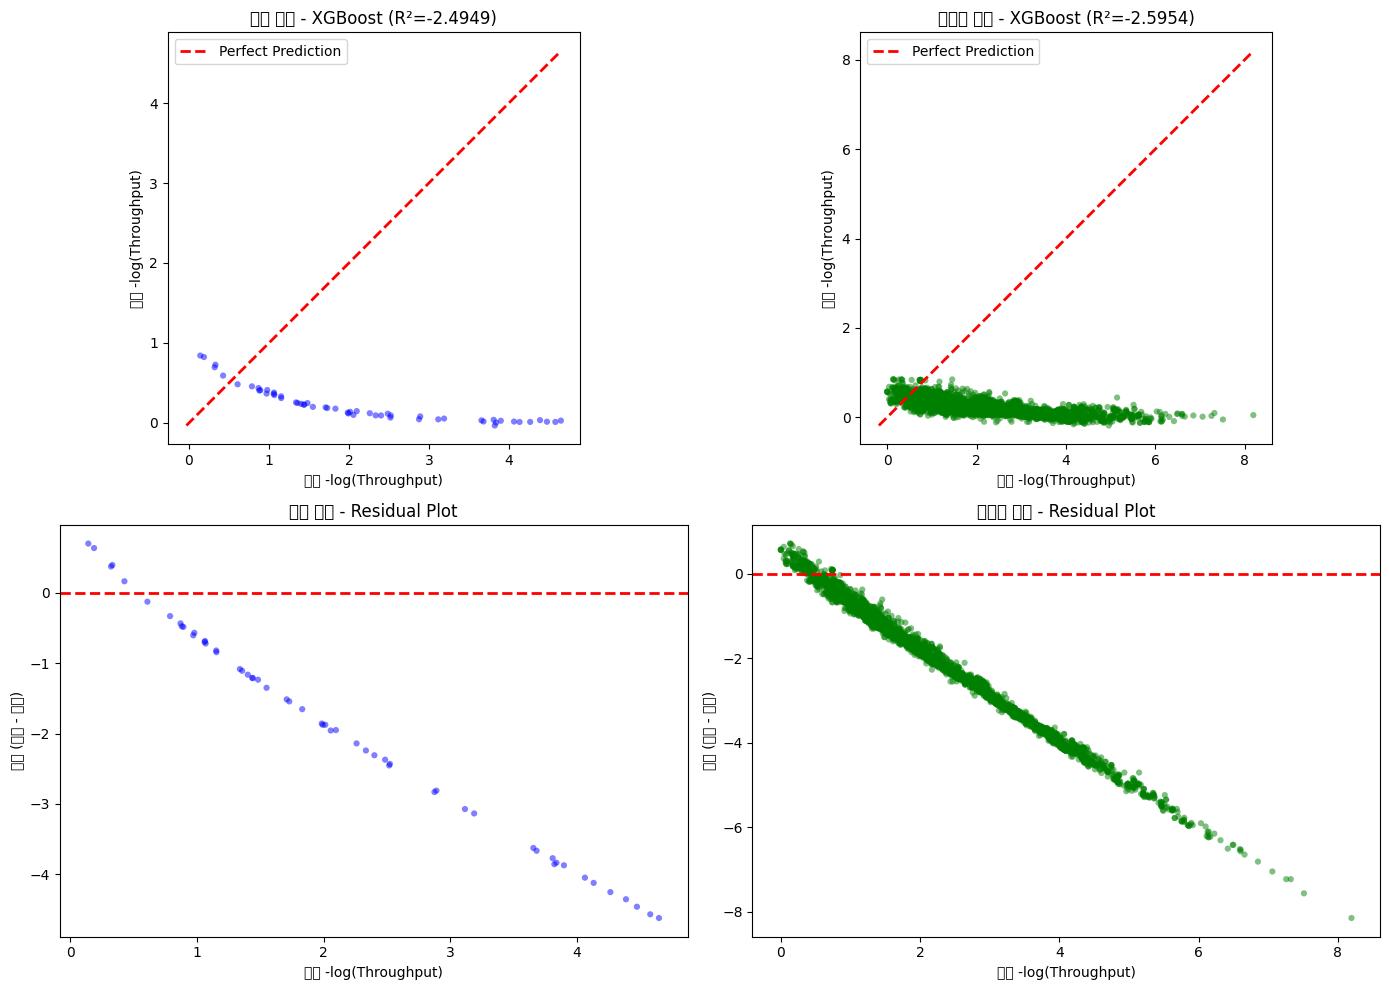


✅ XGBoost 모델 시각화 완료! 'xgboost_model_results.png' 파일로 저장되었습니다.


In [36]:
# XGBoost 모델 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 훈련 세트 - Prediction vs Actual
ax1 = axes[0, 0]
ax1.scatter(train_targets_all, train_preds_all, alpha=0.5, s=20, c='blue', edgecolors='none')
min_val = min(train_targets_all.min(), train_preds_all.min())
max_val = max(train_targets_all.max(), train_preds_all.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('실제 -log(Throughput)')
ax1.set_ylabel('예측 -log(Throughput)')
ax1.set_title(f'훈련 세트 - XGBoost (R²={train_metrics["r2"]:.4f})')
ax1.legend()
ax1.set_aspect('equal', adjustable='box')

# 2. 테스트 세트 - Prediction vs Actual
ax2 = axes[0, 1]
ax2.scatter(test_targets_all, test_preds_all, alpha=0.5, s=20, c='green', edgecolors='none')
min_val = min(test_targets_all.min(), test_preds_all.min())
max_val = max(test_targets_all.max(), test_preds_all.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('실제 -log(Throughput)')
ax2.set_ylabel('예측 -log(Throughput)')
ax2.set_title(f'테스트 세트 - XGBoost (R²={test_metrics["r2"]:.4f})')
ax2.legend()
ax2.set_aspect('equal', adjustable='box')

# 3. 훈련 세트 - Residual Plot
ax3 = axes[1, 0]
train_residuals = train_preds_all - train_targets_all
ax3.scatter(train_targets_all, train_residuals, alpha=0.5, s=20, c='blue', edgecolors='none')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('실제 -log(Throughput)')
ax3.set_ylabel('잔차 (예측 - 실제)')
ax3.set_title('훈련 세트 - Residual Plot')

# 4. 테스트 세트 - Residual Plot
ax4 = axes[1, 1]
test_residuals = test_preds_all - test_targets_all
ax4.scatter(test_targets_all, test_residuals, alpha=0.5, s=20, c='green', edgecolors='none')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('실제 -log(Throughput)')
ax4.set_ylabel('잔차 (예측 - 실제)')
ax4.set_title('테스트 세트 - Residual Plot')

plt.tight_layout()
plt.savefig('xgboost_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ XGBoost 모델 시각화 완료! 'xgboost_model_results.png' 파일로 저장되었습니다.")

In [37]:
# SegmentDataLoader 패턴에 맞춰 데이터 준비
raw_features = list(dataset.features.values())[0]
raw_throughputs = list(dataset.throughputs.values())[0]

# 가변 길이 features와 labels를 리스트로 저장
features_list = []  # 각 샘플의 feature (seq_len, feature_dim)
costs = []
segment_sizes_list = []  # 각 샘플의 segment 길이

for feature, throughput in zip(raw_features, raw_throughputs):
    # throughput은 이미 필터링되어 1e-10 이하인 값이 없음
    # segment 길이가 1이 아닌 것만 선택
    if feature.shape[0] != 1:
        features_list.append(feature)
        # -log(throughput)로 변환
        costs.append(-np.log(throughput))
        segment_sizes_list.append(feature.shape[0])

# numpy array로 변환
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes_list, dtype=np.int32)

# 모든 features를 flatten (SegmentDataLoader 방식)
flatten_features = np.concatenate(features_list, axis=0).astype(np.float32)

print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")
print(f"Cost (-log(throughput)) - Min: {costs.min():.4f}, Max: {costs.max():.4f}, Mean: {costs.mean():.4f}")

총 샘플 수: 3464
Flatten된 features shape: (27712, 164)
Segment sizes - Min: 8, Max: 8, Mean: 8.00
Cost (-log(throughput)) - Min: -0.0000, Max: 8.1969, Mean: 2.3726


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


f_features = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_features.npy')
f_throughputs = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_throughputs.npy')
f_costs = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_costs.npy')
f_segments = []
for feature in f_features:
    f_segments.append(feature.shape[0])


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.95, random_state=SEED)

train_segment_sizes = f_segments[train_indices]
val_segment_sizes = f_segments[val_indices]
train_labels = f_costs[train_indices]
val_labels = f_costs[val_indices]

train_feature_list = [f_features[i] for i in train_indices]
val_feature_list = [f_features[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [ ]:
f_features = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_features.npy')
f_throughputs = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_throughputs.npy')
f_costs = np.load('/root/work/tlm/gen/vae_experiments/pre_experiments/for_ablation/f_costs.npy')



# Train/Val 분할
n_samples = len(f_features)
indices = np.arange(f_features)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

In [5]:
# ============================================================
# MLP Regression 모델 정의 (VAECostPredictor 참고)
# ============================================================
# 각 segment의 row를 인코딩 → segment sum → regression head

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class MLPRegressionModel(nn.Module):
    """
    MLP 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → regression_head → cost
    
    특징:
    - 각 row를 MLP로 인코딩
    - Segment 내 row들을 합산하여 segment-level representation 생성
    - Regression head로 cost 예측
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=128, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(MLPRegressionModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== Latent Projection (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_latent = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        """
        Full encoding path: features → latent z
        """
        # Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # Latent Projection
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h  # Residual
        h = self.l1(h) + h  # Residual
        
        z = self.fc_latent(h)  # (n_seg, latent_dim)
        
        return z, segment_sum_vec
    
    def predict_cost(self, z):
        """z → cost prediction"""
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass: input → z → cost
        
        Returns:
            cost_pred: 예측된 cost
            z: latent vector
        """
        z, segment_sum_vec = self.encode(segment_sizes, features)
        cost_pred = self.predict_cost(z)
        
        return cost_pred, z
    
    def get_encoder_params(self):
        """Encoder 파라미터"""
        encoder_params = []
        encoder_params.extend(self.segment_encoder.parameters())
        encoder_params.extend(self.norm.parameters())
        encoder_params.extend(self.l0.parameters())
        encoder_params.extend(self.l1.parameters())
        encoder_params.extend(self.fc_latent.parameters())
        return encoder_params
    
    def get_predictor_params(self):
        """Predictor 파라미터"""
        return self.cost_predictor.parameters()


# Loss 함수 정의
def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """기본 회귀 손실"""
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """Pairwise ranking loss"""
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    labels = torch.sign(true_j - true_i).float()
    loss = F.margin_ranking_loss(pred_j.view(-1), pred_i.view(-1), labels.view(-1), margin=margin)
    return loss


print("✅ MLPRegressionModel 정의 완료!")
print("특징:")
print("  - Segment Encoder → Segment Sum → Latent Projection → Cost Predictor")
print("  - 전체 forward 경로 미분 가능")

✅ MLPRegressionModel 정의 완료!
특징:
  - Segment Encoder → Segment Sum → Latent Projection → Cost Predictor
  - 전체 forward 경로 미분 가능


In [34]:
# ============================================================
# Phase 단위 학습 (batch_size=64, 2 phases)
# ============================================================

def train_phase_mlp(model, phase_indices, train_features_list, train_segment_sizes, 
                    train_labels, optimizer, device, config, fea_norm_vec=None):
    """
    MLP 모델을 위한 Phase 단위 학습.
    """
    model.train()
    
    # Phase 데이터 준비
    phase_features = [train_features_list[i] for i in phase_indices]
    phase_segment_sizes = train_segment_sizes[phase_indices]
    phase_labels = train_labels[phase_indices]
    
    # Flatten features
    flatten_features = np.concatenate(phase_features, axis=0).astype(np.float32)
    
    # Tensor 변환
    segment_sizes_tensor = torch.tensor(phase_segment_sizes, dtype=torch.int32).to(device)
    features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(phase_labels, dtype=torch.float32).to(device)
    
    # 정규화 적용
    if fea_norm_vec is not None:
        features_tensor = features_tensor / fea_norm_vec.to(device)
    
    # Forward
    cost_pred, z = model(segment_sizes_tensor, features_tensor)
    
    # Loss 계산
    reg_loss = reg_loss_fn(cost_pred, labels_tensor, loss_type=config.get('loss_type', 'mse'))
    pair_loss = pair_loss_fn(cost_pred, labels_tensor, margin=config.get('margin', 0.1))
    
    total_loss = reg_loss + config.get('lambda_pair', 0.1) * pair_loss
    
    # Backward
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return {
        'total_loss': total_loss.item(),
        'reg_loss': reg_loss.item(),
        'pair_loss': pair_loss.item(),
    }


def evaluate_model_mlp(model, val_loader, device, fea_norm_vec=None):
    """
    Validation set 평가
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for segment_sizes, features, labels in val_loader:
            cost_pred, z = model(segment_sizes, features)
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    metrics = {
        'val_mse': mean_squared_error(all_targets, all_preds),
        'val_mae': mean_absolute_error(all_targets, all_preds),
        'val_r2': r2_score(all_targets, all_preds),
    }
    
    model.train()
    return metrics, all_preds, all_targets


# 모델 초기화 (파라미터 수 감소 + 반복 실험) - 목표 R² >= 0.8
input_dim = train_flatten_features.shape[1]
print(f"Input dimension: {input_dim}")

# 더 많은 phase와 다양한 설정으로 R² >= 0.8 목표
experiments = [
    # 더 많은 phase로 학습
    {'name': 'Deep-v1', 'hidden': 128, 'latent': 64, 'pred_hidden': 128, 'pred_layers': 3, 'enc_lr': 1e-2, 'pred_lr': 1e-2, 'phases': 50},
    {'name': 'Deep-v2', 'hidden': 128, 'latent': 64, 'pred_hidden': 128, 'pred_layers': 4, 'enc_lr': 5e-3, 'pred_lr': 5e-3, 'phases': 80},
    {'name': 'Deep-v3', 'hidden': 256, 'latent': 128, 'pred_hidden': 128, 'pred_layers': 3, 'enc_lr': 1e-2, 'pred_lr': 1e-2, 'phases': 100},
    {'name': 'Wide-v1', 'hidden': 256, 'latent': 128, 'pred_hidden': 256, 'pred_layers': 3, 'enc_lr': 5e-3, 'pred_lr': 5e-3, 'phases': 100},
    {'name': 'Wide-v2', 'hidden': 512, 'latent': 256, 'pred_hidden': 256, 'pred_layers': 3, 'enc_lr': 1e-3, 'pred_lr': 1e-3, 'phases': 150},
]

all_results = []
samples_per_phase = 64
best_final_model = None
best_final_state = None
best_final_r2 = -float('inf')

print(f"=" * 70)
print(f"반복 실험 시작 - 목표: R² >= 0.8")
print(f"=" * 70)

for exp in experiments:
    print(f"\n{'='*70}")
    print(f"실험: {exp['name']}")
    print(f"  hidden={exp['hidden']}, latent={exp['latent']}, pred_hidden={exp['pred_hidden']}")
    print(f"  pred_layers={exp['pred_layers']}, enc_lr={exp['enc_lr']}, pred_lr={exp['pred_lr']}")
    print(f"  phases={exp['phases']}")
    print(f"{'='*70}")
    
    # 모델 생성
    model = MLPRegressionModel(
        input_dim=input_dim,
        hidden_dim=exp['hidden'],
        latent_dim=exp['latent'],
        predictor_hidden=exp['pred_hidden'],
        predictor_layers=exp['pred_layers'],
        dropout=0.0,
    ).to(device)
    
    n_params = sum(p.numel() for p in model.parameters())
    print(f"  파라미터 수: {n_params:,}")
    
    model_config = {
        'loss_type': 'mse',
        'lambda_pair': 0.0,
        'margin': 0.05,
    }
    
    optimizer = torch.optim.AdamW([
        {'params': model.get_encoder_params(), 'lr': exp['enc_lr']},
        {'params': model.get_predictor_params(), 'lr': exp['pred_lr']},
    ], weight_decay=0)
    
    # 인덱스 셔플
    all_indices = np.arange(len(train_labels))
    np.random.shuffle(all_indices)
    
    best_r2 = -float('inf')
    best_state = None
    history_exp = []
    
    for phase in range(exp['phases']):
        start_idx = (phase * samples_per_phase) % len(all_indices)
        end_idx = start_idx + samples_per_phase
        if end_idx > len(all_indices):
            # 순환
            phase_indices = np.concatenate([all_indices[start_idx:], all_indices[:end_idx - len(all_indices)]])
        else:
            phase_indices = all_indices[start_idx:end_idx]
        
        loss_info = train_phase_mlp(
            model=model,
            phase_indices=phase_indices,
            train_features_list=train_feature_list,
            train_segment_sizes=train_segment_sizes,
            train_labels=train_labels,
            optimizer=optimizer,
            device=device,
            config=model_config,
            fea_norm_vec=fea_norm_vec,
        )
        
        val_metrics, val_preds_temp, val_targets_temp = evaluate_model_mlp(model, val_loader, device, fea_norm_vec)
        
        history_exp.append({
            'phase': phase + 1,
            'train_loss': loss_info['total_loss'],
            'val_r2': val_metrics['val_r2'],
            'val_mse': val_metrics['val_mse'],
        })
        
        if val_metrics['val_r2'] > best_r2:
            best_r2 = val_metrics['val_r2']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        # 전체 best 모델 저장
        if val_metrics['val_r2'] > best_final_r2:
            best_final_r2 = val_metrics['val_r2']
            best_final_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_final_model = exp.copy()
            best_final_preds = val_preds_temp.copy()
            best_final_targets = val_targets_temp.copy()
        
        if (phase + 1) % 10 == 0 or phase == 0:
            print(f"  Phase {phase+1}: Train Loss={loss_info['total_loss']:.4f}, Val R²={val_metrics['val_r2']:.4f}")
    
    print(f"  ★ Best R²: {best_r2:.4f}")
    
    all_results.append({
        'name': exp['name'],
        'params': n_params,
        'best_r2': best_r2,
        'history': history_exp,
        'config': exp,
        'best_state': best_state,
    })
    
    # 목표 달성 시 조기 종료
    if best_r2 >= 0.8:
        print(f"\n🎉 목표 달성! R² = {best_r2:.4f}")
        break

print(f"\n{'='*70}")
print("실험 결과 요약")
print(f"{'='*70}")
for r in all_results:
    status = "✅" if r['best_r2'] >= 0.8 else "❌"
    print(f"{status} {r['name']}: R²={r['best_r2']:.4f}, params={r['params']:,}")

Input dimension: 164
반복 실험 시작 - 목표: R² >= 0.8

실험: Deep-v1
  hidden=128, latent=64, pred_hidden=128
  pred_layers=3, enc_lr=0.01, pred_lr=0.01
  phases=50
  파라미터 수: 121,409
  Phase 1: Train Loss=8.8142, Val R²=-2.7644
  Phase 10: Train Loss=1.2243, Val R²=-1.5630
  Phase 20: Train Loss=0.5182, Val R²=-0.6693
  Phase 30: Train Loss=0.7247, Val R²=-114.4436
  Phase 40: Train Loss=0.5442, Val R²=-0.9361
  Phase 50: Train Loss=0.4229, Val R²=-0.7517
  ★ Best R²: 0.3335

실험: Deep-v2
  hidden=128, latent=64, pred_hidden=128
  pred_layers=4, enc_lr=0.005, pred_lr=0.005
  phases=80
  파라미터 수: 138,177
  Phase 1: Train Loss=10.6933, Val R²=-3.1347
  Phase 10: Train Loss=0.6169, Val R²=0.0811
  Phase 20: Train Loss=0.4492, Val R²=0.1053
  Phase 30: Train Loss=0.3527, Val R²=-3.9393
  Phase 40: Train Loss=0.4106, Val R²=-5.3073
  Phase 50: Train Loss=0.3569, Val R²=-12.7040
  Phase 60: Train Loss=0.3241, Val R²=-0.2683
  Phase 70: Train Loss=0.4156, Val R²=-0.7469
  Phase 80: Train Loss=0.4231, Val

/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py:87: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_46027/3868175933.py

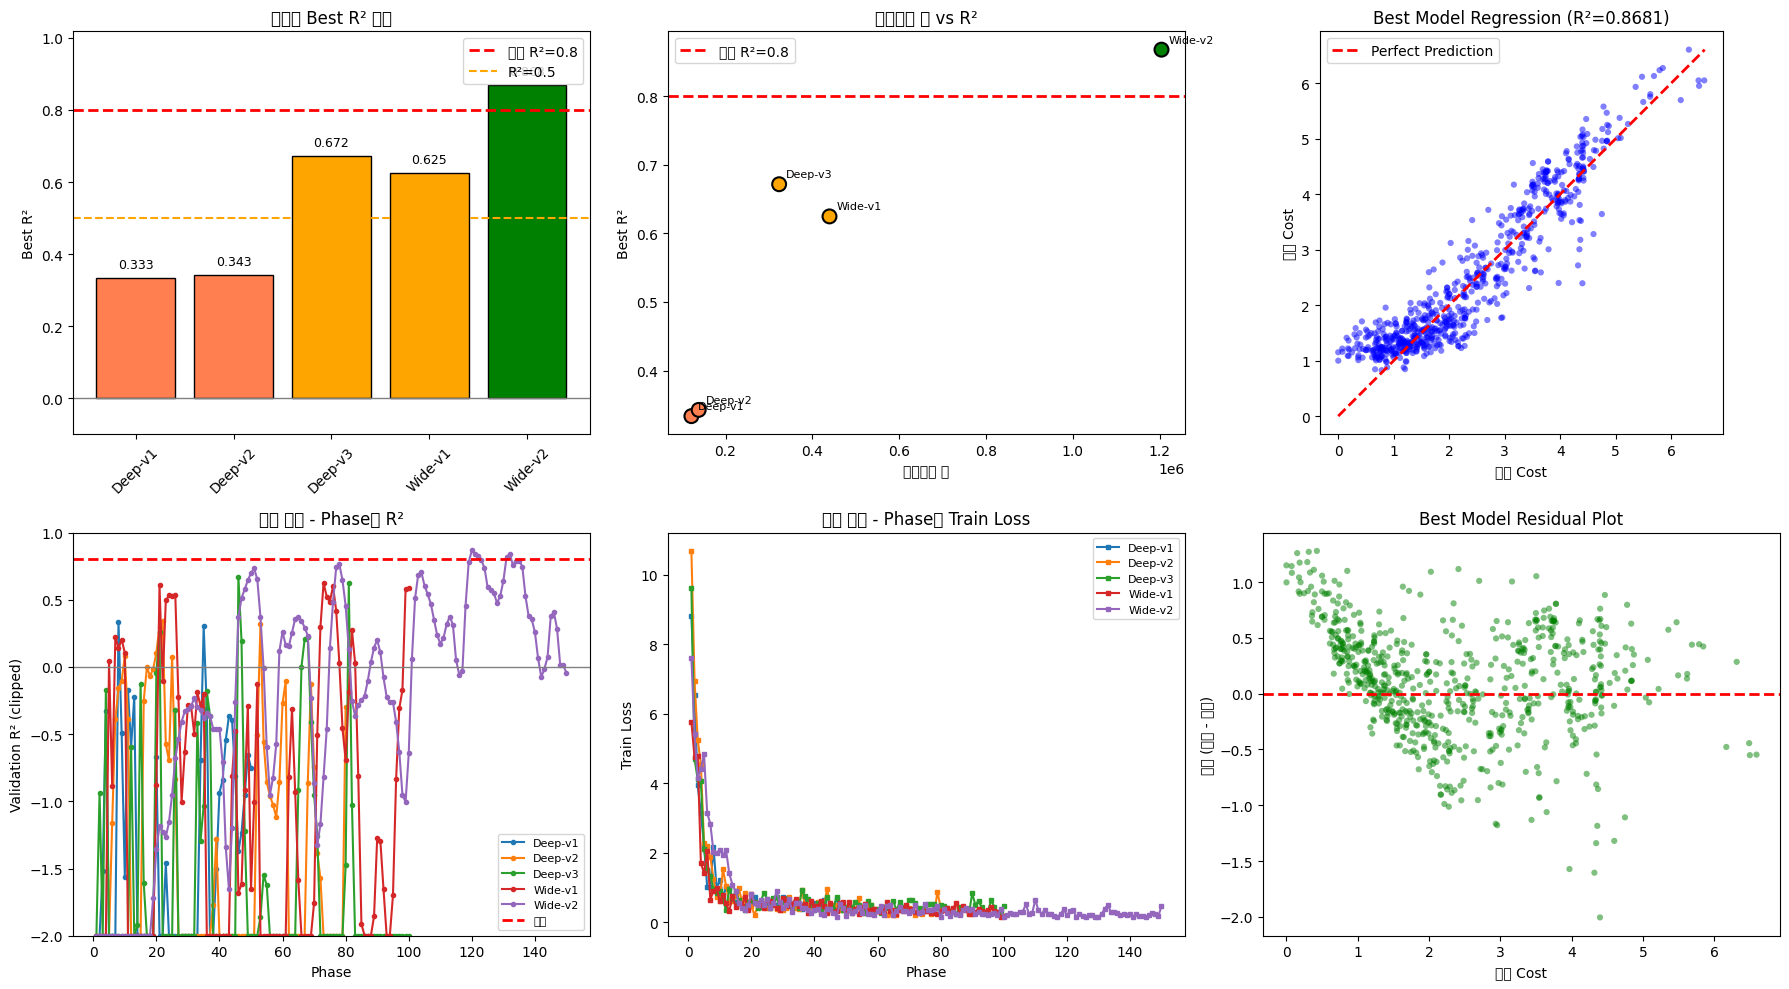


최종 실험 결과 테이블
모델                      파라미터    Best R²   hidden   latent   pred_h   layers   phases
------------------------------------------------------------------------------------------
❌ Deep-v1           121,409     0.3335      128       64      128        3       50
❌ Deep-v2           138,177     0.3426      128       64      128        4       80
❌ Deep-v3           323,457     0.6718      256      128      128        3      100
❌ Wide-v1           439,425     0.6248      256      128      256        3      100
✅ Wide-v2         1,203,969     0.8681      512      256      256        3      150

🏆 Best 모델: Wide-v2
   - R²: 0.8681
   - 파라미터 수: 1,203,969
   - 설정: {'name': 'Wide-v2', 'hidden': 512, 'latent': 256, 'pred_hidden': 256, 'pred_layers': 3, 'enc_lr': 0.001, 'pred_lr': 0.001, 'phases': 150}


In [35]:
# ============================================================
# 결과 시각화 (Best Model Regression Plot 포함)
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 모델별 Best R² 비교 (Bar Chart)
ax1 = axes[0, 0]
names = [r['name'] for r in all_results]
r2_values = [r['best_r2'] for r in all_results]
colors = ['green' if r2 >= 0.8 else ('orange' if r2 >= 0.5 else 'coral') for r2 in r2_values]
bars = ax1.bar(names, r2_values, color=colors, edgecolor='black')
ax1.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='목표 R²=0.8')
ax1.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.5, label='R²=0.5')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax1.set_ylabel('Best R²')
ax1.set_title('모델별 Best R² 비교')
ax1.legend()
ax1.set_ylim(min(min(r2_values), 0) - 0.1, max(r2_values) + 0.15)
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 2. 파라미터 수 vs R² (Scatter)
ax2 = axes[0, 1]
params = [r['params'] for r in all_results]
ax2.scatter(params, r2_values, s=100, c=colors, edgecolors='black', linewidths=1.5)
for i, r in enumerate(all_results):
    ax2.annotate(r['name'], (params[i], r2_values[i]), 
                 textcoords="offset points", xytext=(5, 5), fontsize=8)
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='목표 R²=0.8')
ax2.set_xlabel('파라미터 수')
ax2.set_ylabel('Best R²')
ax2.set_title('파라미터 수 vs R²')
ax2.legend()

# 3. Best Model - Regression Plot (예측 vs 실제)
ax3 = axes[0, 2]
ax3.scatter(best_final_targets, best_final_preds, alpha=0.5, s=20, c='blue', edgecolors='none')
# 대각선 (완벽한 예측)
min_val = min(best_final_targets.min(), best_final_preds.min())
max_val = max(best_final_targets.max(), best_final_preds.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('실제 Cost')
ax3.set_ylabel('예측 Cost')
ax3.set_title(f'Best Model Regression (R²={best_final_r2:.4f})')
ax3.legend()
ax3.set_aspect('equal', adjustable='box')

# 4. 학습 곡선 (Phase별 R²)
ax4 = axes[1, 0]
for r in all_results:
    phases = [h['phase'] for h in r['history']]
    r2s = [h['val_r2'] for h in r['history']]
    r2s_clipped = [max(min(v, 1.0), -2.0) for v in r2s]
    ax4.plot(phases, r2s_clipped, marker='o', label=r['name'], markersize=3)
ax4.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='목표')
ax4.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax4.set_xlabel('Phase')
ax4.set_ylabel('Validation R² (clipped)')
ax4.set_title('학습 곡선 - Phase별 R²')
ax4.legend(loc='lower right', fontsize=8)
ax4.set_ylim(-2, 1.0)

# 5. 학습 곡선 (Phase별 Train Loss)
ax5 = axes[1, 1]
for r in all_results:
    phases = [h['phase'] for h in r['history']]
    losses = [h['train_loss'] for h in r['history']]
    ax5.plot(phases, losses, marker='s', label=r['name'], markersize=3)
ax5.set_xlabel('Phase')
ax5.set_ylabel('Train Loss')
ax5.set_title('학습 곡선 - Phase별 Train Loss')
ax5.legend(loc='upper right', fontsize=8)

# 6. Best Model - Residual Plot
ax6 = axes[1, 2]
residuals = best_final_preds - best_final_targets
ax6.scatter(best_final_targets, residuals, alpha=0.5, s=20, c='green', edgecolors='none')
ax6.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax6.set_xlabel('실제 Cost')
ax6.set_ylabel('잔차 (예측 - 실제)')
ax6.set_title(f'Best Model Residual Plot')

plt.tight_layout()
plt.savefig('mlp_experiment_results.png', dpi=150, bbox_inches='tight')
plt.show()

# 결과 테이블 출력
print("\n" + "=" * 90)
print("최종 실험 결과 테이블")
print("=" * 90)
print(f"{'모델':<15} {'파라미터':>12} {'Best R²':>10} {'hidden':>8} {'latent':>8} {'pred_h':>8} {'layers':>8} {'phases':>8}")
print("-" * 90)
for r in all_results:
    c = r['config']
    status = "✅" if r['best_r2'] >= 0.8 else "❌"
    print(f"{status} {r['name']:<12} {r['params']:>12,} {r['best_r2']:>10.4f} {c['hidden']:>8} {c['latent']:>8} {c['pred_hidden']:>8} {c['pred_layers']:>8} {c['phases']:>8}")
print("=" * 90)

# Best 모델 정보
best_result = max(all_results, key=lambda x: x['best_r2'])
print(f"\n🏆 Best 모델: {best_result['name']}")
print(f"   - R²: {best_result['best_r2']:.4f}")
print(f"   - 파라미터 수: {best_result['params']:,}")
print(f"   - 설정: {best_result['config']}")